# Avaliação de Importância das Features

Este notebook carrega os dados, aplica pré-processamento, carrega pipelines otimizados e avalia a importância das features para cada parâmetro (teff, logg, feh) usando RandomForestRegressor. Permite ajustar o threshold de importância acumulada e escolher se usa só as features mais importantes ou todas.

### Configuration

In [3]:
# Seção 1: Importação de Bibliotecas e Configuração Inicial
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import minas as mg
from minas.evaluation.feature_selection import get_important_features, get_important_features_xgb

# Caminho do arquivo de entrada
data_path = '../data/input_jpasgL.csv'
df_base = pd.read_csv(data_path)
df_base.set_index('ID', drop=True, inplace=True)

# Conjuntos de filtros
survey_filter = 'JPAS'
filters = mg.FILTERS[survey_filter]

# Restrição de erro de magnitude
model_rest = '_01'  # '_01' = mais restrito, '_02' = menos restrito

# Tipo de modelo: XGB = xgboost
model_type = 'RF'

# Ajuste automático do sufixo do survey_train conforme o nome do arquivo de entrada
if 'A' in os.path.basename(data_path):
    survey_train = f'{survey_filter}A'
elif 'L' in os.path.basename(data_path):
    survey_train = f'{survey_filter}L'
else:
    survey_train = survey_filter
datetime_str = pd.Timestamp.now().strftime('%Y%m%d%H%M%S')

# Defina o tuning_id_base manualmente ou extraia de um arquivo existente, se necessário
tuning_id_base = '20250923173244'  # Substitua pelo valor correto se necessário


### Hyperparameters

In [4]:
# Defina os parâmetros e hiperparâmetros para cada modelo
param_configs = [
    {
        'param': 'teff',
        'param_aliases': ['teff', 'Teff', 'TEFF', 'TEFF_ADOP', 'TEFF_SPEC', 'T_EFF'],
        'bins': [3000, 4000, 5000, 6000, 7000, 8300],
        'xgb_param_keys': ['colsample_bytree', 'gamma', 'learning_rate', 'max_depth', 'n_estimators', 'subsample', 'random_state'],
        'rf_param_keys': ['max_features', 'min_samples_leaf', 'n_estimators', 'bootstrap', 'max_depth', 'min_samples_split', 'random_state']
    },
    {
        'param': 'logg',
        'param_aliases': ['logg', 'Logg', 'LOGG', 'log g'],
        'bins': [1.0, 2.0, 3.0, 4.0, 5.0],
        'xgb_param_keys': ['colsample_bytree', 'gamma', 'learning_rate', 'max_depth', 'n_estimators', 'subsample', 'random_state'],
        'rf_param_keys': ['max_features', 'min_samples_leaf', 'n_estimators', 'bootstrap', 'max_depth', 'min_samples_split', 'random_state']
    },
    {
        'param': 'feh',
        'param_aliases': ['feh', 'Feh', 'FEH', '[Fe/H]', '[M/H]'],
        'bins': [-2.5, -1.5, -0.5, 0.5, 1.0],
        'xgb_param_keys': ['colsample_bytree', 'gamma', 'learning_rate', 'max_depth', 'n_estimators', 'subsample', 'random_state'],
        'rf_param_keys': ['max_features', 'min_samples_leaf', 'n_estimators', 'bootstrap', 'max_depth', 'min_samples_split', 'random_state']
    }
]

# Gerar os tuning_ids dinamicamente usando o padrão correto
# tuning_id = f'{tuning_id_base}_{survey_train}_{param}{model_rest}_{model_type}'
tuning_ids = [
    f"{tuning_id_base}_{survey_train}_{cfg['param']}{model_rest}_{model_type}" for cfg in param_configs
]

# Caminho base onde os pipelines foram salvos (ajustado para relativo ao notebook)
pipeline_dir = "../tuning/pipeline"

# Importação correta do joblib.load
from joblib import load

# Carregar os pipelines treinados para cada parâmetro e printar hiperparâmetros escolhidos
for config, tuning_id in zip(param_configs, tuning_ids):
    pipeline_path = f"{pipeline_dir}/{tuning_id}_pipeline.joblib"
    pipeline = load(pipeline_path)
    config['pipeline'] = pipeline
    if model_type == 'RF':
        rf = pipeline.named_steps['randomforestregressor']
        print(f"\nHiperparâmetros escolhidos para {config['param']}:")
        for key in config['rf_param_keys']:
            value = getattr(rf, key, None)
            print(f"  {key}: {value}")
        # Salvar hiperparâmetros para uso na avaliação de features
        config['feature_importance_params'] = {k: getattr(rf, k, None) for k in config['rf_param_keys']}
    elif model_type == 'XGB':
        xgb = pipeline.named_steps['xgbregressor']
        print(f"\nHiperparâmetros escolhidos para {config['param']}:")
        for key in config['xgb_param_keys']:
            value = getattr(xgb, key, None)
            print(f"  {key}: {value}")
        config['feature_importance_params'] = {k: getattr(xgb, k, None) for k in config['xgb_param_keys']}
    else:
        raise ValueError("model_type deve ser 'RF' ou 'XGB'")



Hiperparâmetros escolhidos para teff:
  max_features: 20
  min_samples_leaf: 5
  n_estimators: 50
  bootstrap: True
  max_depth: 10
  min_samples_split: 2
  random_state: 42

Hiperparâmetros escolhidos para logg:
  max_features: 20
  min_samples_leaf: 5
  n_estimators: 50
  bootstrap: True
  max_depth: 10
  min_samples_split: 2
  random_state: 42

Hiperparâmetros escolhidos para feh:
  max_features: 20
  min_samples_leaf: 5
  n_estimators: 50
  bootstrap: True
  max_depth: 10
  min_samples_split: 2
  random_state: 42


/home/usuario/anaconda3/envs/mg/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/usuario/anaconda3/envs/mg/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator SelectKBest from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/usuario/anaconda3/envs/mg/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.

### Pre-Process

In [5]:
# Função utilitária para buscar o nome correto da coluna no DataFrame
def get_column(df, aliases):
    for col in aliases:
        if col in df.columns:
            return col
    raise KeyError(f'Nenhuma coluna encontrada para: {aliases}')

# Aplicar filtros comuns uma vez só
df_common = df_base.copy()
max_err = 0.1 if model_rest == '_01' else 0.2  # filtro de erro de magnitude
error_columns = [f + '_err' for f in filters]

# Filtros de erro de magnitude (aplicados uma vez)
for col in error_columns:
    if col in df_common.columns:
        df_common = df_common[df_common[col] <= max_err]

# Filtros gerais (aplicados uma vez)
df_common = df_common.dropna(subset=['Dist'])

# Agora aplicar filtros específicos para cada parâmetro
def print_preproc(param, df, work_df):
    print(f"Pré-processamento concluído para {param}: {len(df)} amostras, shape do work_df: {work_df.shape}")

preprocessed = {}
for config in param_configs:
    param = config['param']
    aliases = config.get('param_aliases', [param])
    
    # Partir do dataframe já filtrado por restrição
    df = df_common.copy()
    
    # Filtros específicos por parâmetro
    if param.lower() == 'teff':
        param_col = get_column(df, aliases)
        df = df[df[param_col] <= 8300]
        err_col_candidates = [c for c in df.columns if (c.lower().startswith('e_teff') or c.lower().endswith('teff_err'))]
        if err_col_candidates:
            err_col = err_col_candidates[0]
            df = df[df[err_col] < 300]
        df = df[df[param_col] != -9999]
        df = df.dropna(subset=[param_col])

    elif param.lower() in ['logg']:
        param_col = get_column(df, aliases)
        err_col_candidates = [c for c in df.columns if (c.lower().startswith('e_'+param.lower()) 
                                                        or c.lower().endswith(param.lower()+'_err'))]
        if err_col_candidates:
            err_col = err_col_candidates[0]
            df = df[df[err_col] < 0.4]
        df = df[df[param_col] != -9999]
        df = df.dropna(subset=[param_col])
    
    elif param.lower() in ['feh']:
        param_col = get_column(df, aliases)
        err_col_candidates = [c for c in df.columns if (c.lower().startswith('e_'+param.lower()) 
                                                        or c.lower().endswith(param.lower()+'_err'))]
        if err_col_candidates:
            err_col = err_col_candidates[0]
            df = df[df[err_col] < 0.4]
        df = df[df[param_col] != -9999]
        df = df.dropna(subset=[param_col])
    

# Cálculo da magnitude absoluta específico para este parâmetro
    df = mg.preprocess.calculate_abs_mag(df, filters, 'Dist')
    
    # Criação do dataframe de trabalho específico para este parâmetro
    work_df = mg.preprocess.assemble_work_df(df, 
                                              filters=filters, 
                                              correction_pairs=None, 
                                              add_colors=True, 
                                              add_combinations=False)
    preprocessed[param] = {'df': df, 'work_df': work_df, 'param_col': param_col}



Iniciando processo de criação do dataframe de trabalho:

  - Adicionando cores ao dataframe... Tempo: 16.55 s

Processo finalizado! Shape da Tabela Gerada: (2060, 1653)
Iniciando processo de criação do dataframe de trabalho:

  - Adicionando cores ao dataframe... Tempo: 9.87 s

Processo finalizado! Shape da Tabela Gerada: (2060, 1653)
Iniciando processo de criação do dataframe de trabalho:

  - Adicionando cores ao dataframe... Tempo: 10.10 s

Processo finalizado! Shape da Tabela Gerada: (2073, 1653)


In [6]:
from minas.evaluation.feature_selection import get_permutation_importance_rf, get_permutation_importance_xgb

n_features_to_save = 10  # Altere este valor para definir quantas features salvar por parâmetro
use_only_important_features = True  # True = só as importantes, False = todas

for config in param_configs:
    param = config['param']
    work_df = preprocessed[param]['work_df']
    df = preprocessed[param]['df']
    param_col = preprocessed[param]['param_col']
    params = config.get('feature_importance_params', None)
    if model_type == 'RF':
        selected_features, df_feat = get_permutation_importance_rf(work_df, df[param_col], n_features_to_save=n_features_to_save, params=params)
    elif model_type == 'XGB':
        selected_features, df_feat = get_permutation_importance_xgb(work_df, df[param_col], n_features_to_save=n_features_to_save, params=params)
    else:
        raise ValueError("model_type deve ser 'RF' ou 'XGB'")
    config['selected_features'] = selected_features
    config['df_feat'] = df_feat
    display(df_feat)
    print(f"Features selecionadas ({model_type}, {param}):", selected_features)


,feature,importance,cumulative_importance
0,(J0590 - J0900),0.002246,0.002246
1,(J0510 - J0860),0.001362,0.003608
2,(J0560 - J0840),0.001234,0.004842
3,(J0570 - J0840),0.001117,0.005959
4,(J0430 - J0840),0.000900,0.006859
...,...,...,...
1648,(J0450 - J0600),-0.000003,0.067890
1649,(J0780 - J0880),-0.000003,0.067887
1650,(J0460 - J0660),-0.000004,0.067883
1651,(J0710 - J0820),-0.000006,0.067877


Features selecionadas (RF, teff): ['(J0590 - J0900)', '(J0510 - J0860)', '(J0560 - J0840)', '(J0570 - J0840)', '(J0430 - J0840)', '(J0510 - iSDSS)', '(J0510 - J0850)', '(J0430 - J0690)', '(J0420 - J0820)', '(J0440 - J0880)']


,feature,importance,cumulative_importance
0,J0760,0.009381,0.009381
1,J0550,0.007744,0.017124
2,J0730,0.005955,0.023079
3,(J0520 - J0630),0.005703,0.028782
4,J0450,0.005696,0.034478
...,...,...,...
1648,(J0720 - J1007),-0.000014,0.403421
1649,(uJAVA - J0820),-0.000015,0.403406
1650,(J0420 - J0820),-0.000016,0.403390
1651,(uJAVA - J0900),-0.000018,0.403372


Features selecionadas (RF, logg): ['J0760', 'J0550', 'J0730', '(J0520 - J0630)', 'J0450', 'J0740', 'J0650', 'J0880', 'J0680', '(J0480 - J0520)']


,feature,importance,cumulative_importance
0,(J0378 - J0430),0.009739,0.009739
1,(J0410 - J0430),0.008160,0.017899
2,(J0378 - J0470),0.006636,0.024535
3,(J0410 - J0440),0.005600,0.030135
4,(J0378 - J0450),0.005372,0.035507
...,...,...,...
1648,(J0870 - J1007),-0.000036,0.492343
1649,(uJAVA - J0840),-0.000039,0.492305
1650,(J0420 - J0820),-0.000052,0.492253
1651,(J0650 - J0910),-0.000053,0.492200


Features selecionadas (RF, feh): ['(J0378 - J0430)', '(J0410 - J0430)', '(J0378 - J0470)', '(J0410 - J0440)', '(J0378 - J0450)', '(uJAVA - J0440)', '(uJAVA - J0430)', '(J0390 - J0510)', '(J0378 - J0440)', '(J0410 - J0490)']


In [7]:
import json
from datetime import datetime

# Defina quantas features importantes quer salvar no arquivo final
n_features_to_save = 10  # Altere este valor conforme desejado

# Defina se quer salvar apenas as features mais importantes (True) ou todas (False)
save_only_important_features = True  # True = salva só as importantes, False = salva todas

# Gera um config_id único para todos os parâmetros (apenas datetime)
now = datetime.now()
config_id = now.strftime('%Y%m%d%H%M%S')
output_dir = 'config'
os.makedirs(output_dir, exist_ok=True)

for config in param_configs:
    param = config['param']
    # Espera-se que selected_features já tenha sido calculado na célula anterior para cada parâmetro
    if save_only_important_features:
        features = config.get('selected_features', [])
        features_to_save = features[:n_features_to_save] if n_features_to_save > 0 else features
    else:
        work_df = preprocessed[param]['work_df']
        features_to_save = list(work_df.columns)
    # Salvar também os hiperparâmetros usados
    hyperparams = config.get('feature_importance_params', {})
    config_dict = {'selected_features': features_to_save, 'config_id': config_id, 'hyperparameters': hyperparams}
    config_path = os.path.join(output_dir, f'{config_id}_{survey_train}_{param}{model_rest}_{model_type}.json')
    with open(config_path, 'w') as f:
        json.dump(config_dict, f, indent=2)
    # Exibir o conteúdo salvo
    print(f'Configuração salva para {param}:')
    print(json.dumps(config_dict, indent=2, ensure_ascii=False))
    print('-'*60)

print(f"Configurações salvas com config_id: {config_id}")

Configuração salva para teff:
{
  "selected_features": [
    "(J0590 - J0900)",
    "(J0510 - J0860)",
    "(J0560 - J0840)",
    "(J0570 - J0840)",
    "(J0430 - J0840)",
    "(J0510 - iSDSS)",
    "(J0510 - J0850)",
    "(J0430 - J0690)",
    "(J0420 - J0820)",
    "(J0440 - J0880)"
  ],
  "config_id": "20251006180439",
  "hyperparameters": {
    "max_features": 20,
    "min_samples_leaf": 5,
    "n_estimators": 50,
    "bootstrap": true,
    "max_depth": 10,
    "min_samples_split": 2,
    "random_state": 42
  }
}
------------------------------------------------------------
Configuração salva para logg:
{
  "selected_features": [
    "J0760",
    "J0550",
    "J0730",
    "(J0520 - J0630)",
    "J0450",
    "J0740",
    "J0650",
    "J0880",
    "J0680",
    "(J0480 - J0520)"
  ],
  "config_id": "20251006180439",
  "hyperparameters": {
    "max_features": 20,
    "min_samples_leaf": 5,
    "n_estimators": 50,
    "bootstrap": true,
    "max_depth": 10,
    "min_samples_split": 2,
  

### Graphics

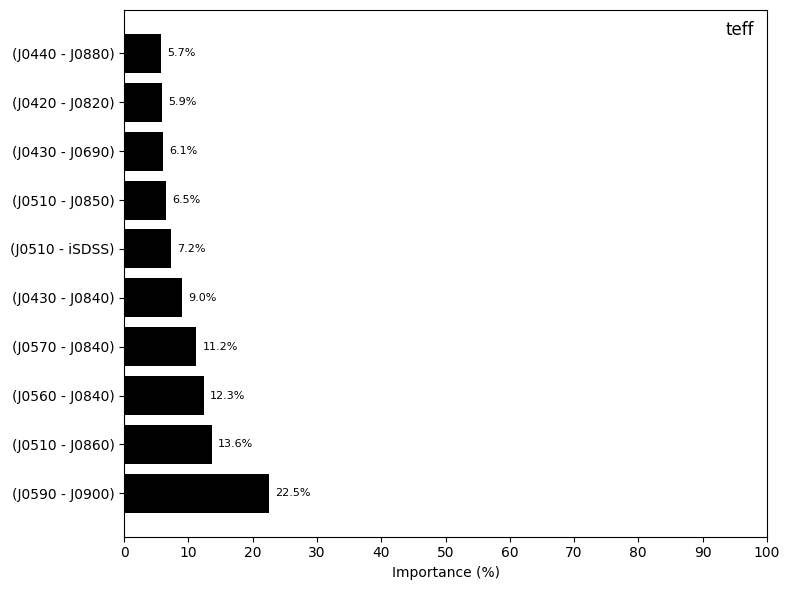

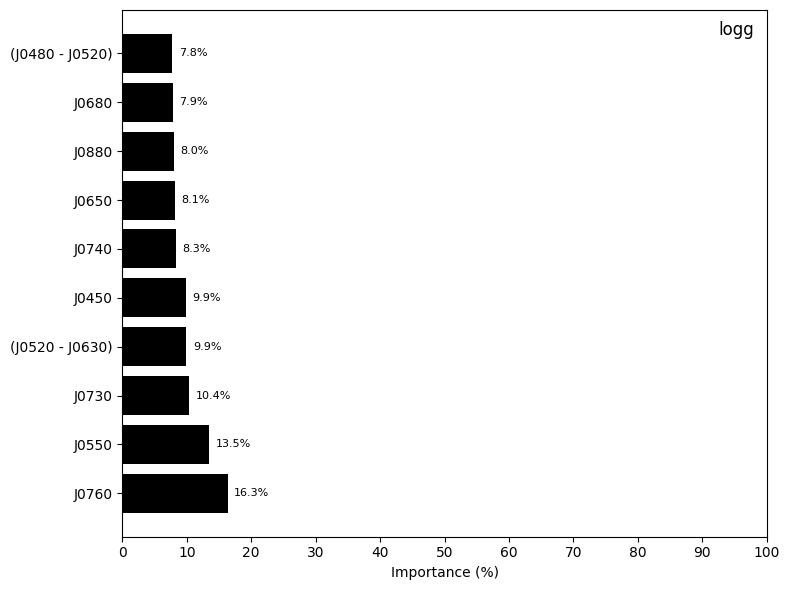

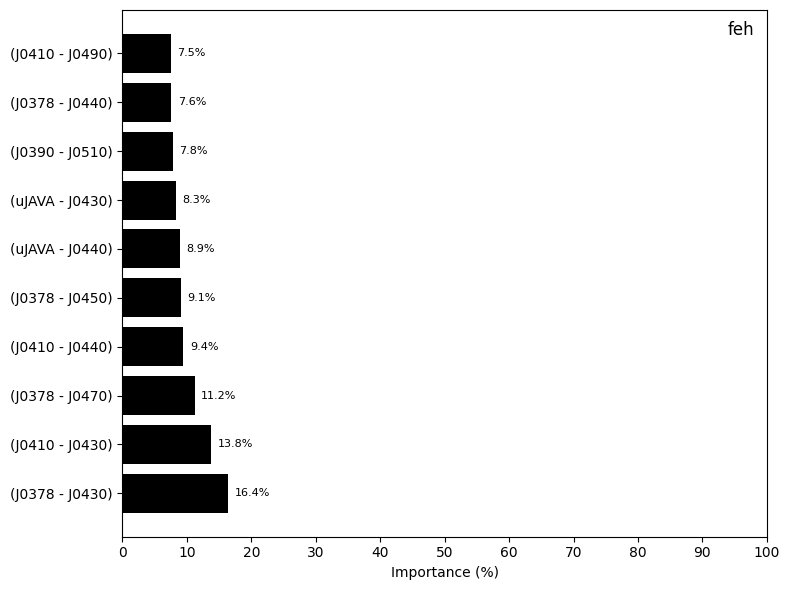

In [12]:
import importlib
import minas.evaluation._graphics
from minas.evaluation.feature_selection import get_important_features, get_important_features_xgb
from minas.evaluation._graphics import plot_feature_importance

importlib.reload(minas.evaluation._graphics)

# Escolha quantas features importantes quer exibir no gráfico
n_top_features_plot = 10  # Altere este valor para mostrar mais ou menos variáveis

# Plotar gráficos de importância das features para todos os parâmetros já avaliados

for config in param_configs:
    param = config['param']
    df_feat = config.get('df_feat', None)
    if df_feat is None:
        # Tentar recalcular e salvar para uso futuro
        work_df = preprocessed[param]['work_df']
        df = preprocessed[param]['df']
        param_col = preprocessed[param]['param_col']
        params = config.get('feature_importance_params', None)
        if model_type == 'RF':
            _, df_feat = get_important_features(work_df, df[param_col], importance_threshold=importance_threshold, params=params)
        elif model_type == 'XGB':
            _, df_feat = get_important_features_xgb(work_df, df[param_col], importance_threshold=importance_threshold, params=params)
        else:
            raise ValueError("model_type deve ser 'RF' ou 'XGB'")
        config['df_feat'] = df_feat  
    plot_feature_importance(df_feat, param, n_top_features=n_top_features_plot)
